In [ ]:
# Cicero tutorial (https://cole-trapnell-lab.github.io/cicero-release/docs/) is followed

In [28]:
BiocManager::install("cicero")
library("cicero")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.18), R 4.1.1 (2021-08-10)

Installing package(s) 'cicero'

also installing the dependencies ‘BiocIO’, ‘restfulr’, ‘AnnotationFilter’, ‘ProtGenerics’, ‘dichromat’, ‘VariantAnnotation’, ‘Rhtslib’, ‘rtracklayer’, ‘GenomicFeatures’, ‘ensembldb’, ‘BSgenome’, ‘biovizBase’, ‘Rsamtools’, ‘GenomicAlignments’, ‘Gviz’, ‘glasso’





The downloaded binary packages are in
	/var/folders/x2/zwp2s_ns3pj8740fxjbvwtnh0000gn/T//RtmpPBBo6F/downloaded_packages


Old packages: 'arrow', 'babelgene', 'bipartite', 'brew', 'clue', 'commonmark',
  'cpp11', 'crayon', 'curl', 'data.table', 'devtools', 'digest', 'dotCall64',
  'DT', 'evaluate', 'foreign', 'gert', 'hdf5r', 'igraph', 'irlba', 'isoband',
  'jsonlite', 'lifecycle', 'mgcv', 'mnormt', 'network', 'nlme', 'nnet',
  'openssl', 'polyclip', 'purrr', 'ragg', 'RcppArmadillo', 'RCurl', 'readr',
  'rgl', 'rmarkdown', 'rpart', 'RSQLite', 'spatstat.data', 'spatstat.sparse',
  'spatstat.utils', 'sys', 'testthat', 'tidyselect', 'vctrs', 'vegan',
  'visNetwork', 'vroom', 'xfun', 'XML', 'yaml'



In [3]:
library("monocle")

In [17]:
#setwd("Desktop/cicero/")

# CICERO Tutorial 

In [4]:
temp <- textConnection(readLines(gzcon(url("http://staff.washington.edu/hpliner/data/kidney_data.txt.gz"))))


In [5]:
cicero_data <- read.table(temp)


In [19]:
dim(cicero_data)

[1] 35137     3

In [7]:
data(cicero_data)
head(cicero_data)

,Peak,Cell,Count
,<chr>,<chr>,<int>
140,chr18_30209631_30210783,AGCGATAGGCGCTATGGTGGAATTCAGTCAGGACGT,4
150,chr18_45820294_45821666,AGCGATAGGTAGCAGCTATGGTAATCCTAGGCGAAG,2
185,chr18_GL456216_random_32820116_32820994,TAATGCGCCGCTTATCGTTGGCAGCTCGGTACTGAC,2
266,chr18_41888433_41890138,AGCGATAGGCGCTATGGTGGAATTCAGTCAGGACGT,2
273,chr18_33038287_33039444,AGCGATAGGGTTATCGAACTCCATCGAGGTACTGAC,2
285,chr18_25533921_25534483,ATTACTCGAACGCGCAGAGGCGGAGGTCGTACTGAC,1


In [8]:
#The output of make_atac_cds is a valid CDS object ready to be input into downstream Cicero functions.

input_cds <- make_atac_cds(cicero_data, binarize = TRUE)

head(input_cds)

# Create a Cicero CDS

Because single-cell chromatin accessibility data is extremely sparse, accurate estimation of co-accessibility scores requires us to aggregate similar cells to create more dense count data. 
Cicero does this using a k-nearest-neighbors approach which creates overlapping sets of cells.

In [10]:
set.seed(2017)
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

In [11]:
input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=6,
                      reduction_method = 'tSNE', norm_method = "none")

In [12]:
tsne_coords <- t(reducedDimA(input_cds))
row.names(tsne_coords) <- row.names(pData(input_cds))
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords)

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 12.5047619047619
Median shared cells bin-bin: 1.5

Warning message in make_cicero_cds(input_cds, reduced_coordinates = tsne_coords):
"On average, more than 10% of cells are shared between paired bins."
Warning message in if (isSparseMatrix(counts)) {:
"the condition has length > 1 and only the first element will be used"


# Run Cicero

The easiest way to get Cicero co-accessibility scores is to run run_cicero. To run run_cicero, you need a cicero CDS object (created above) and a genome coordinates file, which contains the lengths of each of the chromosomes in your organism. 

#Second option: you can also call each function individually and set the parameter according to your dataset. 

In [18]:
data("human.hg19.genome")
sample_genome <- subset(human.hg19.genome, V1 == "chr18")
conns <- run_cicero(cicero_cds, sample_genome) # Takes a few minutes to run
head(conns)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  283"
[1] "Other models: "

Zero or one element in range 
                          30 
[1] "Models with errors:  0"
[1] "Done"


,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr18_10006196_10006822,chr18_9755702_9755970,0.00000000
2,chr18_10006196_10006822,chr18_9756925_9757590,-0.02773593
3,chr18_10006196_10006822,chr18_9771216_9771842,-0.12618972
4,chr18_10006196_10006822,chr18_9781976_9782901,-0.07284726
5,chr18_10006196_10006822,chr18_9784605_9785105,0.00000000
6,chr18_10006196_10006822,chr18_9787597_9788029,0.00000000


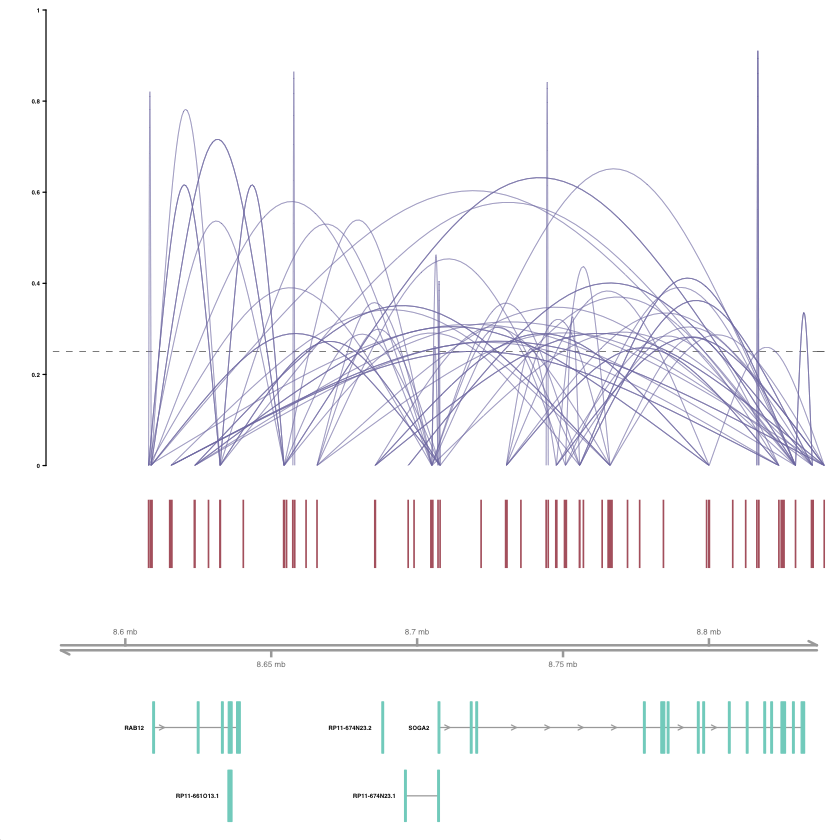

In [20]:
data(gene_annotation_sample)
plot_connections(conns, "chr18", 8575097, 8839855, 
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = .25, 
                connection_width = .5, 
                collapseTranscripts = "longest" )


In [26]:
head(gene_annotation_sample)

,chromosome,start,end,strand,feature,gene,transcript,symbol
,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
411414,chr18,11103,11595,+,lincRNA,ENSG00000262352.1,ENST00000575820.1,AP005530.1
411415,chr18,15617,15822,+,lincRNA,ENSG00000262352.1,ENST00000575820.1,AP005530.1
411416,chr18,11191,11595,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411417,chr18,13152,13354,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411418,chr18,15617,15928,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411419,chr18,45004,45235,+,pseudogene,ENSG00000262181.1,ENST00000575066.1,RP11-683L23.2


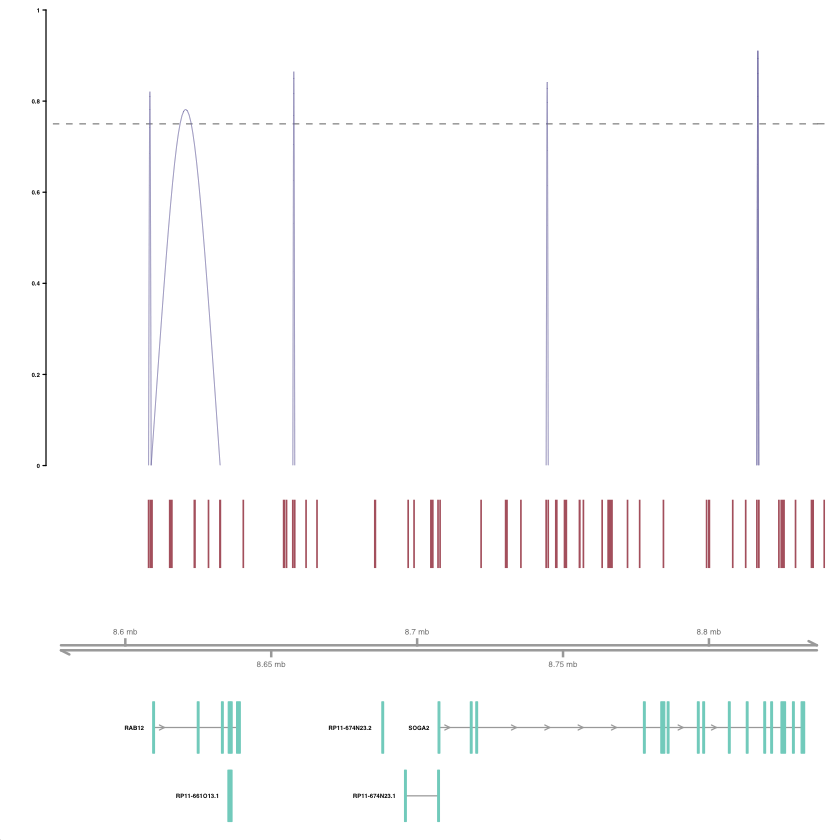

In [27]:
plot_connections(conns, "chr18", 8575097, 8839855, 
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = .75, 
                connection_width = .5, 
                collapseTranscripts = "longest" )

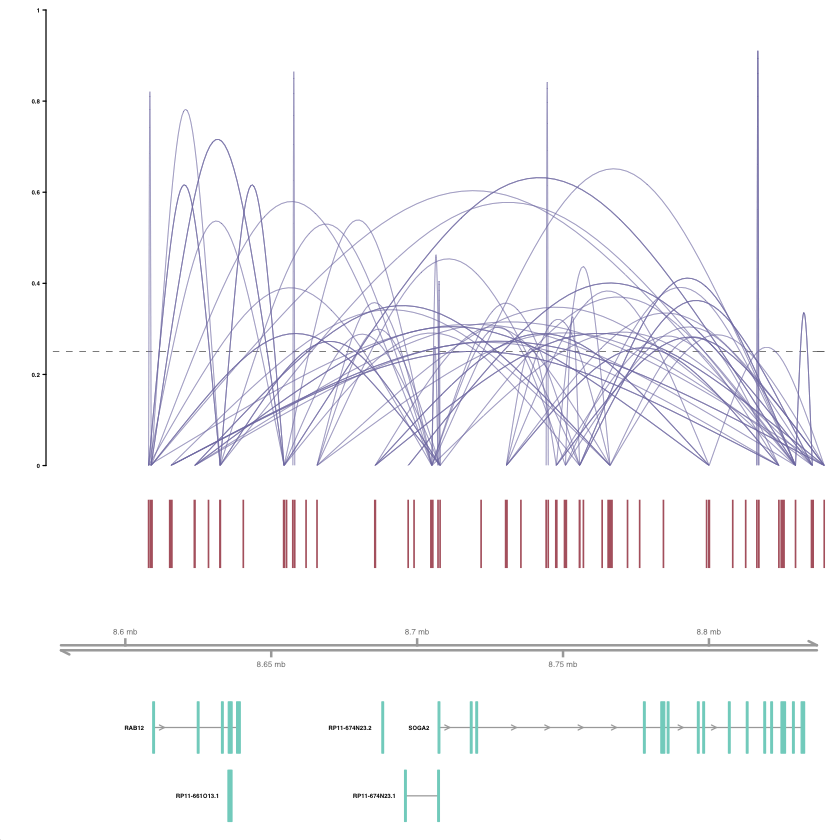

In [23]:
pp<-plot_connections(conns, "chr18", 8575097, 8839855, 
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = .25, 
                connection_width = .5, 
                collapseTranscripts = "longest" )


# Finding cis-Co-accessibility Networks (CCANS)


Cicero also has a function to find Cis-Co-accessibility Networks (CCANs), which are modules of sites that are highly co-accessible with one another. We use the Louvain community detection algorithm (Blondel et al., 2008) to find clusters of sites that tended to be co-accessible.

In [28]:
CCAN_assigns <- generate_ccans(conns)

[1] "Coaccessibility cutoff used: 0.36"


In [32]:
CCAN_assigns

,Peak,CCAN
,<chr>,<dbl>
chr18_10006196_10006822,chr18_10006196_10006822,1
chr18_10010479_10011360,chr18_10010479_10011360,1
chr18_10025_10225,chr18_10025_10225,3
chr18_10032281_10032988,chr18_10032281_10032988,1
chr18_10040565_10041732,chr18_10040565_10041732,1
chr18_10047081_10047763,chr18_10047081_10047763,1
chr18_10057185_10058983,chr18_10057185_10058983,1
chr18_10100928_10101986,chr18_10100928_10101986,1
chr18_10121759_10122789,chr18_10121759_10122789,1


# Add links to a Seurat object 

We can add the co-accessible links found by Cicero to the ChromatinAssay object in Seurat. Using the ConnectionsToLinks() function in Signac we can convert the outputs of Cicero to the format needed to store in the links slot in the ChromatinAssay, and add this to the object using the Links<- assignment function.

In [ ]:
library(Signac)

In [ ]:
links <- ConnectionsToLinks(conns = conns, ccans = ccans)
Links(bone) <- links

In [ ]:
#We can now visualize these links along with DNA accessibility information by running CoveragePlot() for a region:

CoveragePlot(bone, region = "chr1-40189344-40252549")
